In [8]:
import re
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from cgeval.report import GenericReport, plot_binary
from cgeval.distribution import Beta, BetaParams


In [9]:
BASE_PATH = f'../../out/pipeline'

MODEL = {
    # 'Llama-3.3-70B': f'{BASE_PATH}/2025-06-25_sentiment_llama3-3',
    'Llama-2-7B': f'{BASE_PATH}/2025-06-25_sentiment_llama2',
    # 'Mistral-7B': f'{BASE_PATH}/2025-06-25_sentiment_mistral',
}

In [10]:

def load_reports(cfg, report_path, subsampling, i):
    reports = []

    for classifier in cfg.classifier:
        B, M = subsampling

        for i in range(cfg.quantify.subsampling.repeat):
            report = GenericReport()
            report.load(f"{report_path}/{cfg.quantify.out}/subsampling/cls_report_{classifier.id}_{B}_{M}_{i}.json")

            reports.append(report)

    return reports



In [11]:
def get_distributions(cfg, reports):
    distributions = {}

    for idx, cls in enumerate(cfg.classifier):
        report = vars(reports[idx])

        dist = report['dist_report']

        oracle = dist[0]
        p = dist[1]
        p_obs = dist[2]

        oracle_dist = Beta(params=BetaParams(oracle['a'], oracle['b']))
        p_dist = Beta(params=BetaParams(p['a'], p['b']))
        p_obs_dist = Beta(params=BetaParams(p_obs['a'], p_obs['b']))

        distributions[cls.id] = {
            'oracle': oracle_dist,
            'p': p_dist,
            'p_obs': p_obs_dist,
        }

    return distributions


In [12]:
def sample_value(a,b,B,M):
    if M == B:
        return 0

    return (a+b-B)/(M-B)

In [13]:

def get_sample_value_data(cfg, report_path):
    B = cfg.quantify.subsampling.B
    M = cfg.quantify.subsampling.M
    data = []

    for subsampling in list(itertools.product(B, M)):
        b, m = subsampling
        for classifier in cfg.classifier:
            for i in range(cfg.quantify.subsampling.repeat):
                report = GenericReport()
                report.load(f"{report_path}/{cfg.quantify.out}/subsampling/cls_report_{classifier.id}_{b}_{m}_{i}.json")
                report = vars(report)
                dist = report['dist_report']
                p = dist[1]
                p_dist = Beta(params=BetaParams(p['a'], p['b']))

                sv = sample_value(p_dist.params.a, p_dist.params.b, B=b, M=m)

                data.append({
                    'cls': classifier.id,
                    'b': b,
                    'm': m,
                    'i': i,
                    'sample_value': sv,
                })

    return pd.DataFrame(data)

In [14]:
for id, base_path in MODEL.items():
    cfg = OmegaConf.load(f'{base_path}/config.yaml')
    for idx, cls in enumerate(cfg.classifier):
        df = get_sample_value_data(cfg, base_path)
        break
    break

# Compute Sample Values

# Compute Distribution of Sample Values

# Plot Subsampling (Y = Sample Value, X = B) per Metric
# Plot Subsampling (Y = Sample Value, X = M) per Metric
df

FileNotFoundError: [Errno 2] No such file or directory: '../../out/pipeline/2025-06-25_sentiment_llama2/quantify/subsampling/cls_report_lxyuan_DistilBert_0_100_0.json'

In [ ]:
# df['exp'] = df.apply(lambda row: f'{row["b"]}_{row["m"]}', axis=1)

# grouped = df.loc[df['m'] == 10_000].groupby('b')['sample_value']
# grouped.describe()

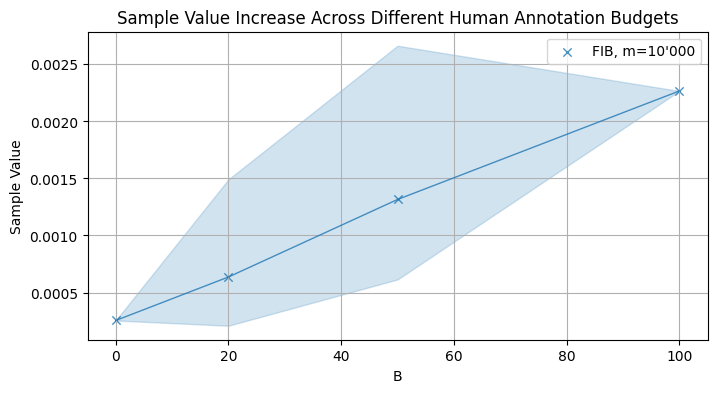

In [ ]:
def plot_sample_value(df, ax, label):
    mean_values = df.mean()

    mean_values = mean_values.sort_index()

    p05 = df.quantile(0.05).sort_index()
    p95 = df.quantile(0.95).sort_index()



    line, = ax.plot(mean_values.index, mean_values.values, lw=1, alpha=.8)
    ax.scatter(mean_values.index, mean_values.values, color=line.get_color(), lw=1, alpha=.8, label=label, marker='x')
    ax.fill_between(p95.index, p05.values, p95.values, color=line.get_color(), alpha=0.2)


fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)

plot_sample_value(df.loc[df['m'] == 10_000].groupby('b')['sample_value'], ax, "FIB, m=10'000")
plot_sample_value(df.loc[df['m'] == 1_000].groupby('b')['sample_value'], ax, "m=1'000")
# plot_sample_value(df.loc[df['m'] == 500].groupby('b')['sample_value'], ax, "m=500")
# plot_sample_value(df.loc[df['m'] == 100].groupby('b')['sample_value'], ax, "m=100")


ax.set_title('Sample Value Increase Across Different Human Annotation Budgets')
ax.set_xlabel('B')
ax.set_ylabel('Sample Value')
ax.legend()
ax.grid()
plt.show()